# Visualizing Canada COVID-19 data
In this notebook we try to gain an understanding of the timeline of the COVID-19 pandemic in Canada

In [157]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
import plotly.express as px
import pandas as pd
import numpy as np
import random
from colour import Color

## Load the data
Data Source: Johns Hopkins CSSE [Github](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)  

In [158]:
url_confirmed = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
df_conf_raw = pd.read_csv(url_confirmed)
df_dead_raw = pd.read_csv(url_deaths)
df_reco_raw = pd.read_csv(url_recovered)

dates = df_conf_raw.columns[4:]
if dates.any():
    print("Data from {} to {}".format(dates[0], dates[-1]))
df_conf = df_conf_raw.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                        value_vars=dates, var_name='Date', value_name='Confirmed')
df_dead = df_dead_raw.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                        value_vars=dates, var_name='Date', value_name='Deaths')
df_reco = df_reco_raw.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                        value_vars=dates, var_name='Date', value_name='Recovered')
#full table combinig all confirmed,recovered and deaths 
df_all = pd.concat([df_conf, df_dead['Deaths'], df_reco['Recovered']], 
                       axis=1, sort=False)
df_all['Active'] = df_all['Confirmed'] - df_all['Deaths'] - df_all['Recovered']

Data from 1/22/20 to 3/28/20


## Briefly Explore Canada cases

In [159]:
df_can = df_all.groupby("Country/Region").get_group("Canada")
df_can.head()

Province/State Country/Region      Lat      Long     Date  Confirmed  \
35           Alberta         Canada  53.9333 -116.5765  1/22/20          0   
36  British Columbia         Canada  49.2827 -123.1207  1/22/20          0   
37    Grand Princess         Canada  37.6489 -122.6655  1/22/20          0   
38          Manitoba         Canada  53.7609  -98.8139  1/22/20          0   
39     New Brunswick         Canada  46.5653  -66.4619  1/22/20          0   

    Deaths  Recovered  Active  
35       0        0.0     0.0  
36       0        0.0     0.0  
37       0        0.0     0.0  
38       0        0.0     0.0  
39       0        0.0     0.0

In [161]:
df_prov = df_can[["Date", "Province/State", "Confirmed"]]#.groupby("Province/State")
px.line(df_prov, x="Date", y="Confirmed", color="Province/State", title="Confirmed Covid-19 Cases in Canada by Province")

## Bar Chart Race
Animate a bar chart race using Matlotlib  
Taken from here and repurposed: [https://www.kaggle.com/aryanc55/covid-19-bar-chart-race](https://www.kaggle.com/aryanc55/covid-19-bar-chart-race)

In [7]:
adj_dates = df_all.Date.unique()

In [8]:
def genratepseudorandomcolors():
    random_i = random.randint(0,10000000)
    random_j = random.randint(0,10000000)
    c = Color(random_i,random_j)
    hex_number = c.hex_l
    return hex_number

In [34]:
def draw_barchart_conf_prov_state(df: pd.DataFrame, country: str, current_date: str, colorsset):

    dff = df[df['Date'].eq(current_date)].groupby('Country/Region').get_group(country).groupby("Province/State").sum().sort_values(by='Confirmed', ascending=False).head(10)
    dff = dff.reset_index()
    dff = dff[::-1]
    
    ax.clear()
    ax.barh(dff['Province/State'], dff['Confirmed'], color=[colorsset[x] for x in dff['Province/State']])
    dx = dff['Confirmed'].max() / 200


    for i, (value, name) in enumerate(zip(dff['Confirmed'], dff['Province/State'])):
        
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    
    total = dff['Confirmed'].sum()
    ax.text(1, 0.4, current_date, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
#     ax.text(0, 1.06, 'Population (thousands)', transform=ax.transAxes, size=12, color='#777777')
    ax.text(1, 0.2, 'Total: {}'.format(total), transform=ax.transAxes, color='#777777', size=32, ha='right', weight=800)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    
    #adding other textual infomations
    ax.text(0, 1.15, 'Number of Confirmed COVID-19 cases in {}'.format(country),
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    plt.box(False)

In [35]:
def get_draw_fn(df: pd.DataFrame):
    colours = []
    for i in range(len(df_all['Country/Region'].unique())) :
        colours.append(genratepseudorandomcolors())

    colorsset = dict(zip(
        [i for i in df_all['Country/Region'].unique()],
        colours
    ))
    def _draw_fn(current_date: str):
        return draw_barchart_conf(df, current_date, colorsset)
    return _draw_fn
def get_draw_fn_country(df: pd.DataFrame, country: str):
    colours = []
    for i in range(len(df.groupby('Country/Region').get_group(country)["Province/State"].unique())) :
        colours.append(genratepseudorandomcolors())
    colorsset = dict(zip(
        [i for i in df.groupby('Country/Region').get_group(country)["Province/State"].unique()],
        colours
    ))
    def _draw_fn(current_date: str):
        return draw_barchart_conf_prov_state(df, country, current_date, colorsset)
    return _draw_fn

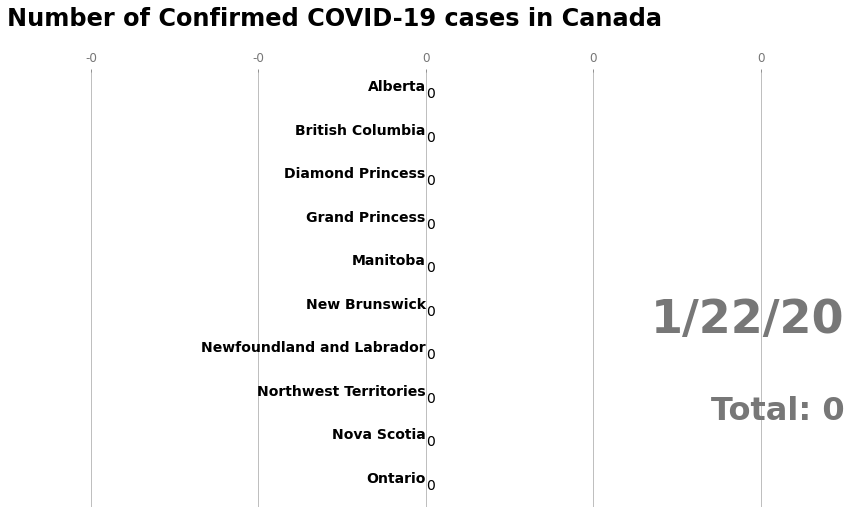

In [36]:
fig, ax = plt.subplots(figsize=(15, 8))
interval = 400  # ms pause btwn frames
animator = animation.FuncAnimation(fig, get_draw_fn_country(df_all, "Canada"), frames=adj_dates, interval=interval)
HTML(animator.to_jshtml())

## Format and save to csv for Flourish app
[Flourish](https://app.flourish.studio) provides a great platform for animating bar charts

In [162]:
df_can_grouped = df_conf_raw.groupby("Country/Region").get_group("Canada")
df_can_grouped["image_url"] = ""
df_can_grouped["image_url"][df_can_grouped["Province/State"] == "Newfoundland and Labrador"] = "https://flagsoveramerica.com/assets/images/sc_images/products/399_image.png"
df_can_grouped["Province/State"][df_can_grouped["Province/State"] == "Newfoundland and Labrador"] = "NL"
df_can_grouped["image_url"][df_can_grouped["Province/State"] == "Prince Edward Island"] = "https://flagsoveramerica.com/assets/images/sc_images/products/404_image.png"
df_can_grouped["Province/State"][df_can_grouped["Province/State"] == "Prince Edward Island"] = "PE"
df_can_grouped["image_url"][df_can_grouped["Province/State"] == "Nova Scotia"] = "https://flagsoveramerica.com/assets/images/sc_images/products/401_image.png"
df_can_grouped["Province/State"][df_can_grouped["Province/State"] == "Nova Scotia"] = "NS"
df_can_grouped["image_url"][df_can_grouped["Province/State"] == "New Brunswick"] = "https://flagsoveramerica.com/assets/images/sc_images/products/398_image.png"
df_can_grouped["Province/State"][df_can_grouped["Province/State"] == "New Brunswick"] = "NB"
df_can_grouped["image_url"][df_can_grouped["Province/State"] == "Quebec"] = "https://flagsoveramerica.com/assets/images/sc_images/products/405_image.png"
df_can_grouped["Province/State"][df_can_grouped["Province/State"] == "Quebec"] = "QC"
df_can_grouped["image_url"][df_can_grouped["Province/State"] == "Ontario"] = "https://flagsoveramerica.com/assets/images/sc_images/products/403_image.png"
df_can_grouped["Province/State"][df_can_grouped["Province/State"] == "Ontario"] = "ON"
df_can_grouped["image_url"][df_can_grouped["Province/State"] == "Manitoba"] = "https://flagsoveramerica.com/assets/images/sc_images/products/397_image.png"
df_can_grouped["Province/State"][df_can_grouped["Province/State"] == "Manitoba"] = "MB"
df_can_grouped["image_url"][df_can_grouped["Province/State"] == "Saskatchewan"] = "https://flagsoveramerica.com/assets/images/sc_images/products/406_image.png"
df_can_grouped["Province/State"][df_can_grouped["Province/State"] == "Saskatchewan"] = "SK"
df_can_grouped["image_url"][df_can_grouped["Province/State"] == "Alberta"] = "https://flagsoveramerica.com/assets/images/sc_images/products/395_image.png"
df_can_grouped["Province/State"][df_can_grouped["Province/State"] == "Alberta"] = "AB"
df_can_grouped["image_url"][df_can_grouped["Province/State"] == "British Columbia"] = "https://flagsoveramerica.com/assets/images/sc_images/products/396_image.png"
df_can_grouped["Province/State"][df_can_grouped["Province/State"] == "British Columbia"] = "BC"
df_can_grouped["image_url"][df_can_grouped["Province/State"] == "Yukon"] = "https://flagsoveramerica.com/assets/images/sc_images/products/407_image.png"
df_can_grouped["Province/State"][df_can_grouped["Province/State"] == "Yukon"] = "YT"
df_can_grouped["image_url"][df_can_grouped["Province/State"] == "Northwest Territories"] = "https://flagsoveramerica.com/assets/images/sc_images/products/400_image.png"
df_can_grouped["Province/State"][df_can_grouped["Province/State"] == "Northwest Territories"] = "NT"
df_can_grouped["image_url"][df_can_grouped["Province/State"] == "Nunavut"] = "https://flagsoveramerica.com/assets/images/sc_images/products/402_image.png"
df_can_grouped["Province/State"][df_can_grouped["Province/State"] == "Nunavut"] = "NU"

df_can_grouped = df_can_grouped[df_can_grouped["Province/State"] != "Recovered"]
df_can_grouped = df_can_grouped[df_can_grouped["Province/State"] != "Diamond Princess"]
df_can_grouped = df_can_grouped[df_can_grouped["Province/State"] != "Grand Princess"]

df_can_grouped.to_csv("./can_covid19_mar28_2020.csv")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/site-packages/ipykernel